## Data Wrangling

Recap of the problem: Corporación Favorita is a large Ecuadorian-based grocery retailer that operates hundreds of supermarkets and needs a forecasting model that will accurately predict the unit sales by product. Variables include store type, location, oil price, promotional information, holiday information and product type. The grocery store wants to ensure they can have just enough of the right products at the right time.The scope of the solution space remains within the 4000 products from 54 different store locations. Our model will not be predicting any unit sales outside of these products and store locations.The data provided has variables that include store number, item number, unit sales, and promotion information. The training data set covers 2013-2016 and the test set data is a 16-day window in 2017. There is store metadata available categorizing stores, listing location. There is also metadata for the products including family, class, and perishable. There is also data on holiday and events to show breaks in the work days. There is also daily oil price included for the time frame of the train and test data. Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Import and Review all datasets

In [3]:
training = pd.read_csv('train.csv', dtype= {'id':int,'store_nbr':int, 'unit_sales':float, 'onpromotion':str}, parse_dates=['date'])
items = pd.read_csv('items.csv')
stores=pd.read_csv('stores.csv')
test=pd.read_csv('test.csv',parse_dates=['date'])
transactions = pd.read_csv('transactions.csv',parse_dates=['date'])
holidays_events=pd.read_csv('holidays_events.csv',parse_dates=['date'])
sample_submission=pd.read_csv('sample_submission.csv')

In [4]:
print(items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int64 
 1   family      4100 non-null   object
 2   class       4100 non-null   int64 
 3   perishable  4100 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 128.3+ KB
None


In [5]:
print(items.head())

   item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520     GROCERY I   1028           0
4    103665  BREAD/BAKERY   2712           1


In [6]:
print(items['family'].value_counts(normalize=True))

family
GROCERY I                     0.325366
BEVERAGES                     0.149512
CLEANING                      0.108780
PRODUCE                       0.074634
DAIRY                         0.059024
PERSONAL CARE                 0.037317
BREAD/BAKERY                  0.032683
HOME CARE                     0.026341
DELI                          0.022195
MEATS                         0.020488
HOME AND KITCHEN I            0.018780
LIQUOR,WINE,BEER              0.017805
FROZEN FOODS                  0.013415
POULTRY                       0.013171
HOME AND KITCHEN II           0.010976
EGGS                          0.010000
CELEBRATION                   0.007561
LAWN AND GARDEN               0.006341
PREPARED FOODS                0.006341
LADIESWEAR                    0.005122
AUTOMOTIVE                    0.004878
LINGERIE                      0.004878
BEAUTY                        0.004634
PLAYERS AND ELECTRONICS       0.004146
SCHOOL AND OFFICE SUPPLIES    0.003659
GROCERY II        

In [7]:
print(items['perishable'].value_counts(normalize=True))

perishable
0    0.759512
1    0.240488
Name: proportion, dtype: float64


In [8]:
print(transactions.head())

        date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922


In [9]:
print(stores.head())

   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4


In [10]:
stores['city'].value_counts(normalize=True)

city
Quito            0.333333
Guayaquil        0.148148
Cuenca           0.055556
Santo Domingo    0.055556
Manta            0.037037
Latacunga        0.037037
Machala          0.037037
Ambato           0.037037
Quevedo          0.018519
Esmeraldas       0.018519
Loja             0.018519
Libertad         0.018519
Playas           0.018519
Daule            0.018519
Babahoyo         0.018519
Salinas          0.018519
Puyo             0.018519
Guaranda         0.018519
Ibarra           0.018519
Riobamba         0.018519
Cayambe          0.018519
El Carmen        0.018519
Name: proportion, dtype: float64

In [11]:
stores['state'].value_counts(normalize=True)

state
Pichincha                         0.351852
Guayas                            0.203704
Santo Domingo de los Tsachilas    0.055556
Azuay                             0.055556
Manabi                            0.055556
Cotopaxi                          0.037037
Tungurahua                        0.037037
Los Rios                          0.037037
El Oro                            0.037037
Chimborazo                        0.018519
Imbabura                          0.018519
Bolivar                           0.018519
Pastaza                           0.018519
Santa Elena                       0.018519
Loja                              0.018519
Esmeraldas                        0.018519
Name: proportion, dtype: float64

In [12]:
stores['type'].value_counts(normalize=True)

type
D    0.333333
C    0.277778
A    0.166667
B    0.148148
E    0.074074
Name: proportion, dtype: float64

In [13]:
print(training.head())

   id       date  store_nbr  item_nbr  unit_sales onpromotion
0   0 2013-01-01         25    103665         7.0         NaN
1   1 2013-01-01         25    105574         1.0         NaN
2   2 2013-01-01         25    105575         2.0         NaN
3   3 2013-01-01         25    108079         1.0         NaN
4   4 2013-01-01         25    108701         1.0         NaN


In [14]:
print(holidays_events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB
None


## Merge the datasets 

In [15]:
items_with_other_info = pd.merge(items,training,on='item_nbr',left_on=None, right_on=None, left_index=False, right_index=False,
                                sort=True,
                                 suffixes=("_item", "_training")).merge(stores,on ='store_nbr', left_on=None, right_on=None,
                              left_index=False, right_index=False, sort=True, suffixes=("_training","_store")).merge(holidays_events,how='left',on ='date', 
                              left_index=False, right_index=False, sort=True, suffixes=("_item","_holiday"))


#items_with_other_info_1=pd.merge(items_with_other_inf,stores, on ='store_nbr', left_on=None, right_on=None,
 #                             left_index=False, right_index=False, sort=True, suffixes=("_training","_store"))
#

#items_with_other_info=pd.merge(items_with_other_info_1,holidays_events, how='left',on ='date', 
 #                             left_index=False, right_index=False, sort=True, suffixes=("_item","_holiday"))

In [16]:
items_with_other_info.rename(columns={'onpromotion':'on_sale'},inplace=True)

In [17]:
items_with_other_info.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)


In [18]:
items_with_other_info.head()

,item_nbr,family,class,perishable,id,date,store_nbr,unit_sales,on_sale,city,state,type_item,cluster,type_holiday,locale,locale_name,description,transferred
0,103665,BREAD/BAKERY,2712,1,0,2013-01-01,25,7.0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
1,105574,GROCERY I,1045,0,1,2013-01-01,25,1.0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
2,105575,GROCERY I,1045,0,2,2013-01-01,25,2.0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
3,108079,GROCERY I,1030,0,3,2013-01-01,25,1.0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False
4,108701,DELI,2644,1,4,2013-01-01,25,1.0,NaN,Salinas,Santa Elena,D,1,Holiday,National,Ecuador,Primer dia del ano,False


## Fill in values with missing on sale information with False.

In [19]:
items_with_other_info['on_sale'].fillna(False, inplace=True)

/var/folders/gq/789ffg0j3_s7scj27n_mdkj40000gn/T/ipykernel_72234/3050791023.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  items_with_other_info['on_sale'].fillna(False, inplace=True)


In [20]:
items_with_other_info.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127970257 entries, 0 to 127970256
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   item_nbr      int64         
 1   family        object        
 2   class         int64         
 3   perishable    int64         
 4   id            int64         
 5   date          datetime64[ns]
 6   store_nbr     int64         
 7   unit_sales    float64       
 8   on_sale       object        
 9   city          object        
 10  state         object        
 11  type_item     object        
 12  cluster       int64         
 13  type_holiday  object        
 14  locale        object        
 15  locale_name   object        
 16  description   object        
 17  transferred   object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(10)
memory usage: 17.2+ GB


## Remove duplicates

In [21]:
duplicated = items_with_other_info.duplicated(keep='last')


In [22]:
items_with_other_info=(items_with_other_info[~duplicated])

In [23]:

print(items_with_other_info)

           item_nbr        family  class  perishable         id       date  \
0            103665  BREAD/BAKERY   2712           1          0 2013-01-01   
1            105574     GROCERY I   1045           0          1 2013-01-01   
2            105575     GROCERY I   1045           0          2 2013-01-01   
3            108079     GROCERY I   1030           0          3 2013-01-01   
4            108701          DELI   2644           1          4 2013-01-01   
...             ...           ...    ...         ...        ...        ...   
127970252   2089339     GROCERY I   1006           0  125497035 2017-08-15   
127970253   2106464     BEVERAGES   1148           0  125497036 2017-08-15   
127970254   2110456     BEVERAGES   1120           0  125497037 2017-08-15   
127970255   2113914      CLEANING   3040           0  125497038 2017-08-15   
127970256   2116416     GROCERY I   1060           0  125497039 2017-08-15   

           store_nbr  unit_sales on_sale       city        stat

## Transform variables that are true/false to booleans. transform class to category

In [24]:
items_with_other_info['perishable']=items_with_other_info['perishable'].astype('bool')
items_with_other_info['on_sale']=items_with_other_info['on_sale'].astype('bool')
items_with_other_info['class']=items_with_other_info['class'].astype('category')

In [25]:
items_with_other_info['locale'].describe()

count     21828208
unique           3
top       National
freq      11468026
Name: locale, dtype: object

In [26]:
items_with_other_info['locale'].value_counts(normalize=True)

locale
National    0.525376
Local       0.411010
Regional    0.063614
Name: proportion, dtype: float64

In [27]:
items_with_other_info['locale_name'].describe()

count     21828208
unique          24
top        Ecuador
freq      11468026
Name: locale_name, dtype: object

In [28]:
items_with_other_info['locale_name'].value_counts(normalize=True)

locale_name
Ecuador                           0.525376
Guayaquil                         0.040786
Riobamba                          0.033699
Latacunga                         0.031156
Guaranda                          0.030665
Quito                             0.030042
Ambato                            0.026682
Cuenca                            0.020843
El Carmen                         0.018724
Santo Domingo                     0.018724
Cayambe                           0.018261
Esmeraldas                        0.017822
Machala                           0.017467
Imbabura                          0.017467
Cotopaxi                          0.017357
Manta                             0.017302
Puyo                              0.016023
Libertad                          0.015723
Salinas                           0.015365
Loja                              0.014425
Santa Elena                       0.014422
Santo Domingo de los Tsachilas    0.014368
Quevedo                           0.013670

In [29]:
items_with_other_info['unit_sales'].describe()

count    1.279703e+08
mean     8.568666e+00
std      2.418040e+01
min     -1.537200e+04
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      8.944000e+04
Name: unit_sales, dtype: float64

## Make sure that unit sales are not less than 0 

In [30]:
items_with_other_info[items_with_other_info['unit_sales']==items_with_other_info['unit_sales'].min()]

,item_nbr,family,class,perishable,id,date,store_nbr,unit_sales,on_sale,city,state,type_item,cluster,type_holiday,locale,locale_name,description,transferred
50191786,1166474,BEVERAGES,1120,False,49592112,2015-06-22,18,-15372.0,True,Quito,Pichincha,B,16,NaN,NaN,NaN,NaN,NaN


## This date is the same date as the massive earthquake in Pichincha. Remove this  and make sure min sales is equal to or more than  0. Explore rows with negative unit sales

In [31]:
item=items_with_other_info[items_with_other_info['item_nbr']==119026]

In [32]:
item[item['unit_sales']<0]


,item_nbr,family,class,perishable,id,date,store_nbr,unit_sales,on_sale,city,state,type_item,cluster,type_holiday,locale,locale_name,description,transferred
80625721,119026,CLEANING,3026,False,79204331,2016-05-14,53,-4673.0,True,Manta,Manabi,D,13,Event,National,Ecuador,Terremoto Manabi+28,False


In [33]:
subset=items_with_other_info[items_with_other_info['item_nbr']==119026]['unit_sales'].max()
items_with_other_info.loc[subset]

item_nbr                     903955
family                    BEVERAGES
class                          1122
perishable                    False
id                             4720
date            2013-01-02 00:00:00
store_nbr                         4
unit_sales                      5.0
on_sale                       False
city                          Quito
state                     Pichincha
type_item                         D
cluster                           9
type_holiday                    NaN
locale                          NaN
locale_name                     NaN
description                     NaN
transferred                     NaN
Name: 4720, dtype: object

In [34]:
items_with_other_info[items_with_other_info['unit_sales']<0]


,item_nbr,family,class,perishable,id,date,store_nbr,unit_sales,on_sale,city,state,type_item,cluster,type_holiday,locale,locale_name,description,transferred
10655,456875,CLEANING,3015,False,10655,2013-01-02,10,-3.0,False,Quito,Pichincha,C,15,NaN,NaN,NaN,NaN,NaN
46867,559044,BREAD/BAKERY,2716,True,46867,2013-01-03,5,-1.0,False,Santo Domingo,Santo Domingo de los Tsachilas,D,4,NaN,NaN,NaN,NaN,NaN
50970,365138,GROCERY I,1072,False,50970,2013-01-03,9,-3.0,False,Quito,Pichincha,B,6,NaN,NaN,NaN,NaN,NaN
71807,812716,"LIQUOR,WINE,BEER",1318,False,71807,2013-01-03,41,-19.0,False,Machala,El Oro,D,4,NaN,NaN,NaN,NaN,NaN
71992,1004551,"LIQUOR,WINE,BEER",1318,False,71992,2013-01-03,41,-27.0,False,Machala,El Oro,D,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127874614,682884,CLEANING,3004,False,125401397,2017-08-15,4,-1.0,True,Quito,Pichincha,D,9,Holiday,Local,Riobamba,Fundacion de Riobamba,False
127877333,1455485,BEVERAGES,1152,False,125404116,2017-08-15,5,-1.0,True,Santo Domingo,Santo Domingo de los Tsachilas,D,4,Holiday,Local,Riobamba,Fundacion de Riobamba,False
127880437,215303,GROCERY I,1026,False,125407220,2017-08-15,7,-1.0,True,Quito,Pichincha,D,8,Holiday,Local,Riobamba,Fundacion de Riobamba,False
127882512,2048193,GROCERY I,1016,False,125409295,2017-08-15,7,-1.0,True,Quito,Pichincha,D,8,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [35]:
items_with_other_info[items_with_other_info['unit_sales']<0]['state'].value_counts(normalize=True)


state
Pichincha                         0.558764
Guayas                            0.169513
Tungurahua                        0.044576
Azuay                             0.040934
Santo Domingo de los Tsachilas    0.030136
Los Rios                          0.022099
El Oro                            0.020467
Santa Elena                       0.020216
Loja                              0.018835
Manabi                            0.018709
Cotopaxi                          0.015193
Imbabura                          0.011175
Bolivar                           0.009920
Esmeraldas                        0.008287
Chimborazo                        0.007534
Pastaza                           0.003641
Name: proportion, dtype: float64

In [36]:
items_with_other_info[items_with_other_info['unit_sales']<0]['type_item'].value_counts(normalize=True)


type_item
D    0.434706
A    0.257283
B    0.140382
C    0.118031
E    0.049598
Name: proportion, dtype: float64

In [37]:
items_with_other_info[items_with_other_info['unit_sales']<0]['transferred'].value_counts(normalize=True)


transferred
False    0.967742
True     0.032258
Name: proportion, dtype: float64

In [38]:
items_with_other_info[items_with_other_info['unit_sales']<0]['on_sale'].value_counts(normalize=True)


on_sale
True     0.834882
False    0.165118
Name: proportion, dtype: float64

In [39]:
items_with_other_info[items_with_other_info['unit_sales']>=0]['on_sale'].value_counts(normalize=True)


on_sale
True     0.828962
False    0.171038
Name: proportion, dtype: float64

In [40]:
items_with_other_info[items_with_other_info['unit_sales']>=0].describe()


,item_nbr,id,date,store_nbr,unit_sales,cluster
count,1.279623e+08,1.279623e+08,127962293,1.279623e+08,1.279623e+08,1.279623e+08
mean,9.736219e+05,6.291530e+07,2015-09-17 20:32:52.574583296,2.746758e+01,8.570442e+00,8.727179e+00
min,9.699500e+04,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,1.000000e-03,1.000000e+00
25%,5.227210e+05,3.154549e+07,2014-09-23 00:00:00,1.200000e+01,2.000000e+00,4.000000e+00
50%,9.595020e+05,6.315291e+07,2015-11-26 00:00:00,2.800000e+01,4.000000e+00,9.000000e+00
75%,1.354382e+06,9.414972e+07,2016-10-17 00:00:00,4.300000e+01,9.000000e+00,1.300000e+01
max,2.127114e+06,1.254970e+08,2017-08-15 00:00:00,5.400000e+01,8.944000e+04,1.700000e+01
std,5.208501e+05,3.620335e+07,NaN,1.632959e+01,2.410391e+01,4.626471e+00


In [41]:
items_with_other_info[items_with_other_info['unit_sales']<0].describe()


,item_nbr,id,date,store_nbr,unit_sales,cluster
count,7.964000e+03,7.964000e+03,7964,7964.000000,7964.000000,7964.000000
mean,1.060949e+06,6.503037e+07,2015-10-14 01:43:47.222501376,26.119161,-19.968299,9.237192
min,9.699500e+04,1.065500e+04,2013-01-02 00:00:00,1.000000,-15372.000000,1.000000
25%,5.929420e+05,3.397509e+07,2014-10-28 00:00:00,8.000000,-4.000000,5.000000
50%,1.105213e+06,6.639718e+07,2015-12-31 00:00:00,25.000000,-1.000000,9.000000
75%,1.463887e+06,9.730684e+07,2016-11-18 00:00:00,44.000000,-1.000000,13.000000
max,2.121610e+06,1.254730e+08,2017-08-15 00:00:00,54.000000,-0.002000,17.000000
std,5.404696e+05,3.634282e+07,NaN,17.230871,243.152178,4.677962


In [42]:
items_with_other_info=items_with_other_info[items_with_other_info['unit_sales']>=0]

## Visualize the data to see how many items are in each family and how many are persihable

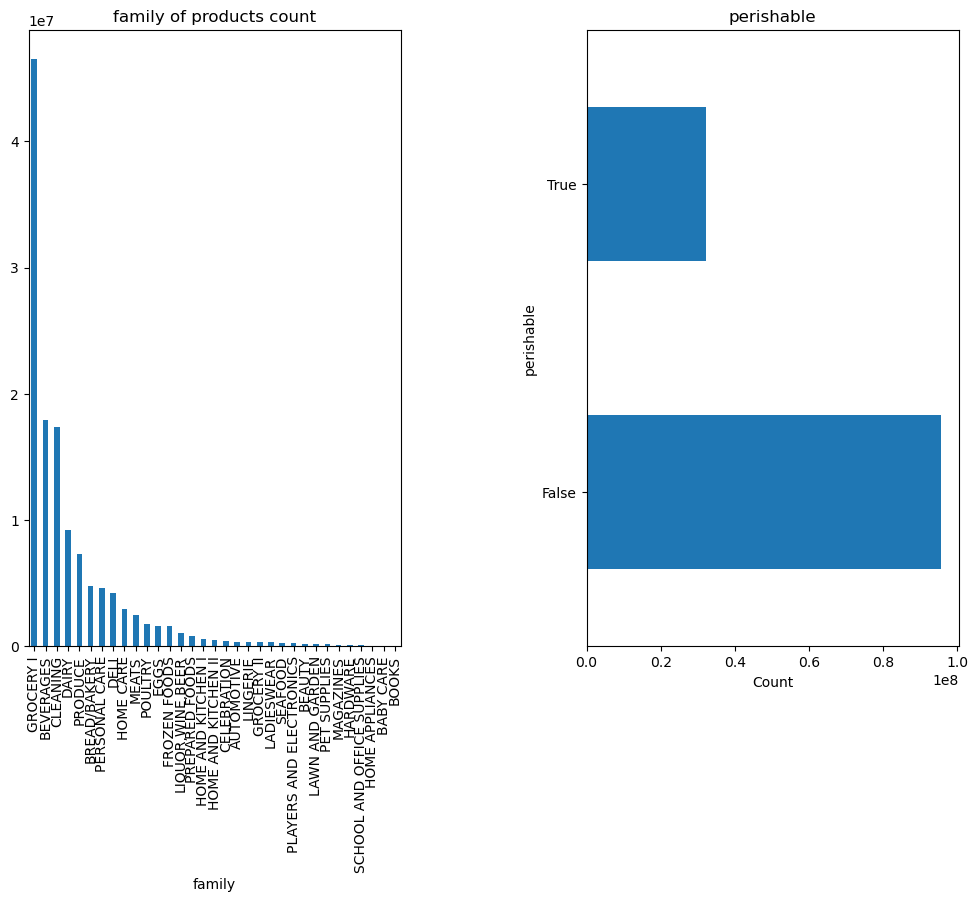

In [50]:

#Code task 13#
#Create two subplots on 1 row and 2 columns with a figsize of (12, 8)
fig, ax = plt.subplots(1, 2, figsize=(12,8))
#Specify a horizontal barplot ('barh') as kind of plot (kind=)
items_with_other_info.family.value_counts().plot(kind='bar', ax=ax[0])
#Give the plot a helpful title of 'Region'
ax[0].set_title('family of products count')
#Label the xaxis 'Count'
#Give the plot a helpful title of 'state'
items_with_other_info.perishable.value_counts().plot(kind='barh', ax=ax[1])
ax[1].set_title('perishable')
#Label the xaxis 'Count'
ax[1].set_xlabel('Count')
#Give the subplots a little "breathing room" with a wspace of 0.5
plt.subplots_adjust(wspace=0.5);
#You're encouraged to explore a few

In [43]:
items_with_other_info.rename(columns={'onpromotion':'on_sale'},inplace=True)

Text(0.5, 1.0, 'perishable')

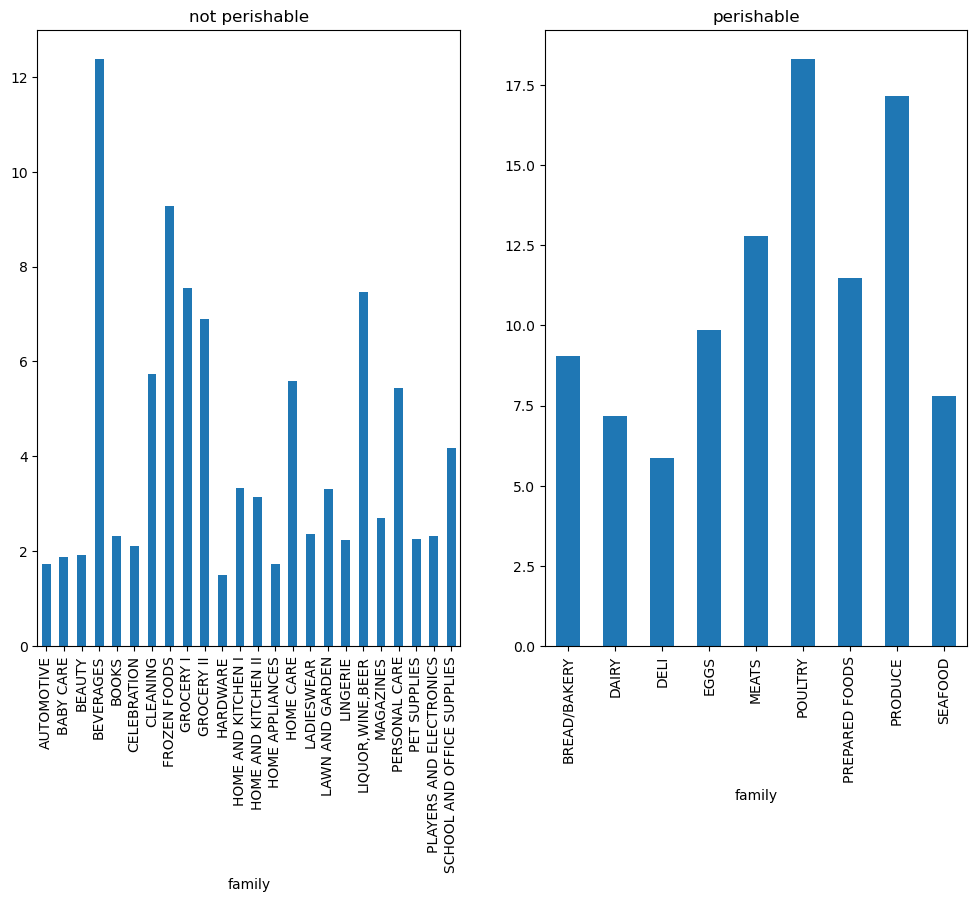

In [46]:
df=items_with_other_info.groupby('family')['unit_sales'].mean()
df_not_perishable_grouped=items_with_other_info[items_with_other_info['perishable']==0].groupby('family')['unit_sales'].mean()
df_perishable_grouped=items_with_other_info[items_with_other_info['perishable']==1].groupby('family')['unit_sales'].mean()

#Code task 13#
#Create two subplots on 1 row and 2 columns with a figsize of (12, 8)
fig,ax = plt.subplots(1, 2, figsize=(12,8))
#Specify a horizontal barplot ('barh') as kind of plot (kind=)
df_not_perishable_grouped.plot(kind='bar',ax=ax[0])
df_perishable_grouped.plot(kind='bar',ax=ax[1])
#Give the plot a helpful title of 'Region'
ax[0].set_title('not perishable')
ax[1].set_title('perishable')


              
              # importing pandas library 

<Axes: xlabel='family'>

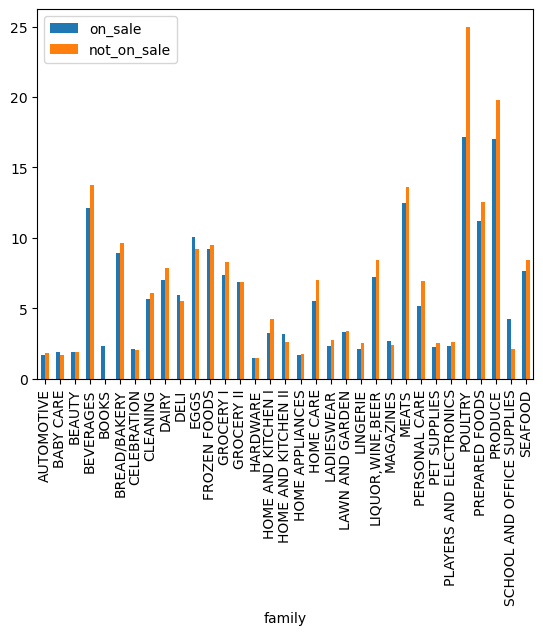

In [47]:
df_not_on_sale_grouped=items_with_other_info[items_with_other_info['on_sale']==False].groupby('family')['unit_sales'].mean()
df_on_sale_ungrouped=items_with_other_info[items_with_other_info['on_sale']==True]
df_on_sale_grouped = df_on_sale_ungrouped.groupby('family')['unit_sales'].mean()
# plotting graph 
new_df = pd.DataFrame({'on_sale':df_on_sale_grouped, 'not_on_sale':df_not_on_sale_grouped}).reset_index()
new_df.plot(x='family',y=["on_sale", "not_on_sale"], kind="bar") 

## visualize how many items from each category are on sale or not on sale

<Axes: xlabel='family'>

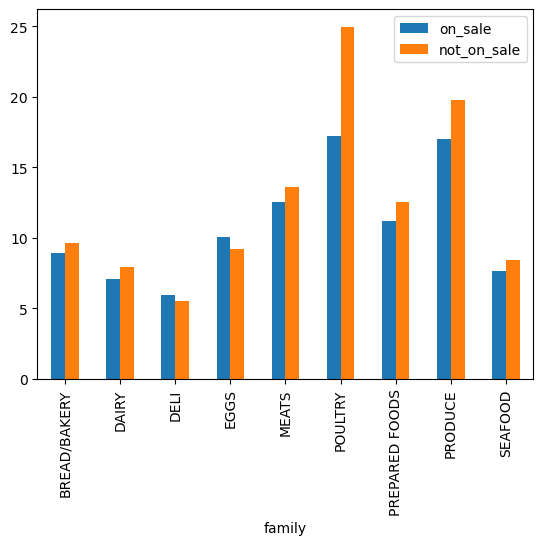

In [48]:
df_perishable_on_sale_grouped=items_with_other_info[(items_with_other_info['on_sale']==True)&(items_with_other_info['perishable']==1)].groupby('family')['unit_sales'].mean()
df_perishable_not_on_sale_grouped=items_with_other_info[(items_with_other_info['on_sale']==False)&(items_with_other_info['perishable']==1)].groupby('family')['unit_sales'].mean()
#Code task 13#
perish_df = pd.DataFrame({'on_sale':df_perishable_on_sale_grouped, 'not_on_sale':df_perishable_not_on_sale_grouped}).reset_index()
perish_df.plot(x='family',y=["on_sale", "not_on_sale"], kind="bar")

<Axes: xlabel='family'>

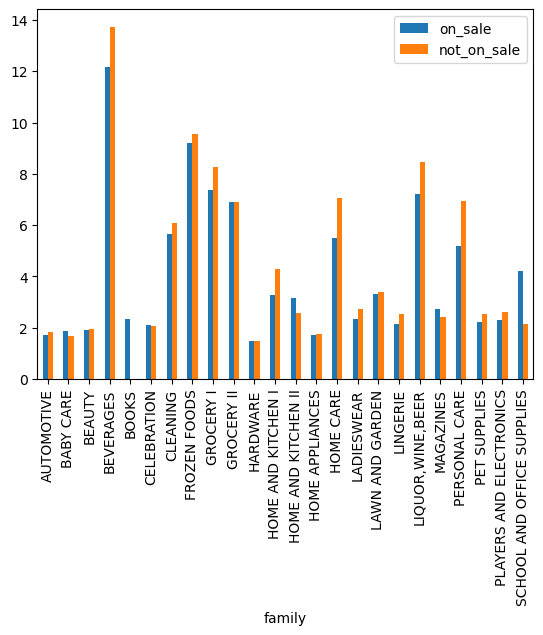

In [49]:

df_notperishable_on_sale_grouped=items_with_other_info[(items_with_other_info['on_sale']==True)&(items_with_other_info['perishable']==0)].groupby('family')['unit_sales'].mean()
df_notperishable_not_on_sale_grouped=items_with_other_info[(items_with_other_info['on_sale']==False)&(items_with_other_info['perishable']==0)].groupby('family')['unit_sales'].mean()
#Code task 13#
notperish_df = pd.DataFrame({'on_sale':df_notperishable_on_sale_grouped, 'not_on_sale':df_notperishable_not_on_sale_grouped}).reset_index()
notperish_df.plot(x='family',y=["on_sale", "not_on_sale"], kind="bar")

In [45]:
output_file = 'all_info.csv'
items_with_other_info.to_csv(output_file, index=True)